In [236]:
import pandas as pd
import warnings
from sodapy import Socrata
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt


MTA_client = Socrata("data.ny.gov", None)

ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests': '7tfn-twae'
}

In [238]:
def get_dataset(ds_name: str, begin: str=None, before: str=None, MTA_client=None) -> pd.DataFrame:
    """
    retrieves a pandas dataframe from a corresponding MTA data source
    filters for optional start and end times; careful not passing any start or end times - over 100 million rows for hourly data
    assumes the existence of MTA_client
    """
    sample = MTA_client.get(ds_dictionary[ds_name], limit=1)
    time_columns = [v for v in sample[0].keys() if v.lower().endswith(('date', 'timestamp', 'month'))]
    if MTA_client is None: raise Exception('MTA_client not found; required for connection to data repository')
    
    if len(time_columns) == 0:
        warnings.warn(f'No time column found: {sample[0].keys}')
        try:
            res_dict = MTA_client.get_all(ds_dictionary[ds_name])
            return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)
        except Exception as e:
            raise Exception(f"Couldn't get all rows. Too many? {e}")

    if len(time_columns) > 1:
        raise Exception(f'Too many time columns found: {sample.keys}')

    time_column = time_columns[0]
    where_string = f"{time_column} >= '{begin}'" if begin and not before else ''
    where_string = f"{time_column} < '{before}'" if not begin and before else ''
    where_string = f"{time_column} >= '{begin}' AND {time_column} < '{before}'" if begin and before else ''
    res_dict = MTA_client.get_all(ds_dictionary[ds_name], where=where_string, order=f'{time_column} ASC')
    return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)


def rid_irrelevant_criteria(df: pd.DataFrame, kept: dict) -> pd.DataFrame:
    """
    for a given pandas dataframe, drop column values that match a list of kept values
    ie., kept: {'metrics': 'Arrests'} -> all rows w/o 'Arrests' for 'metrics' column are dropped
    """
    keys = set(kept.keys())
    if keys.intersection(set(df.columns)) != keys:
        raise Exception(f'Kept columns not found in dataframe: {keys.intersection(set(df.columns))}')
    for key in keys:
        if set(df[key].unique()).intersection(kept[key]) != kept[key]:
            raise Exception(f'At least one kept value from column {key} DNE: {kept[key]}') 
    
    for key in keys: 
        df = df.where(df[key].isin(kept[key])).dropna().reset_index(drop=True)
    return df


def aggregate_by_timeframe(df: pd.DataFrame, timeframe: str, typ: str) -> pd.DataFrame:
    """
    aggregates a timeframe by timeframe; results are summed or averaged
    """
    if timeframe not in ['hourly', 'daily', 'weekly', 'monthly']:
        raise Exception(f'Invalid timeframe {timeframe}')
    if typ not in ['mean', 'sum']:
        raise Exception(f'Invalid type {typ}')
    
    time_columns = [v for v in df.columns if v.lower().endswith(('date', 'timestamp', 'month'))]
    if len(time_columns) != 1:
        raise Exception(f'Zero or more than one time column(s) found: {df.columns}')

    time_column = time_columns[0]
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    for column in df.columns:
        if column != time_column:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')
            except TypeError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')

    df = df.set_index(time_column)
    timeframe_dictionary = {'hourly': 'h', 'daily': 'd', 'weekly': 'W', 'monthly': 'ME'}

    if typ == 'mean': return df.resample(timeframe_dictionary[timeframe]).mean(numeric_only=True).reset_index() 
    if typ == 'sum': return df.resample(timeframe_dictionary[timeframe]).sum(numeric_only=True).reset_index() 


In [242]:
df_crimes = get_dataset('summonses and arrests', MTA_client=MTA_client)
df_crimes = rid_irrelevant_criteria(df_crimes,
        {'metric': {
            'Fare Evasion Arrests',
            'Fare Evasion Criminal Summons',
            'Fare Evasion TABS Summons',
            'Fare Evasion Summons'}})

C:\Users\zclle\AppData\Local\Temp\ipykernel_31088\658531659.py:69: UserWarning: Column agency disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')
C:\Users\zclle\AppData\Local\Temp\ipykernel_31088\658531659.py:69: UserWarning: Column police_force disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')
C:\Users\zclle\AppData\Local\Temp\ipykernel_31088\658531659.py:69: UserWarning: Column metric disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')


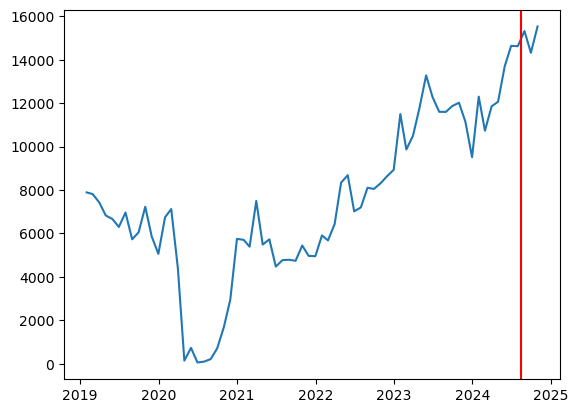

In [259]:
df_crimes_agg = aggregate_by_timeframe(df_crimes, 'monthly', 'sum')
plt.plot(df_crimes_agg.month, df_crimes_agg.total)
plt.axvline(datetime.strptime('2024-08-14', '%Y-%m-%d'), color='red')

In [304]:
import requests
from bs4 import BeautifulSoup
import newspaper
from tqdm import tqdm


def get_articles_by_query(query: str, start: str, end: str, page: int=0):
    """
    gets all relevant news articles by query (google search), returns articles between start and end dates 'YYYY-MM-DD'
    recalls itself if search results == 10: an indication that there are more results next page
    
    ***WARNING: DO NOT CALL UNNECESSARILY - GOOGLE MAY IP-BAN BOT ACTIVITY; BE MINDFUL OF FREQUENT USE***

    """
    url = f'https://www.google.com/search?q={'+'.join(query.split())}+after:{start}+before:{end}+&tbm=nws&start={page * 10}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = []
    
    for link in soup.find_all('a'):
        weblink = str(link['href'])
        if weblink[:15] == '/url?q=https://' and '.google.com' not in weblink:
            articles.append(weblink[7:].split('&')[0])

    if len(articles) == 0:
        return []
    if len(articles) < 10:
        return articles
    articles.extend(get_articles_by_query(query, start, end, page + 1))
    return articles


def get_articles_df(articles, drop_unfound_published_timestamp=True):
    """
    converts a list of articles into a pandas DataFrame through newspaper3k
    some articles (~10%) cannot be parsed for unknown reason, TODO
    some articles could be parsed but their published_date cannot be automatically collected
    """
    ret_dict = {'title': [],  'timestamp': [], 'text': [], 'link': []}
    for index in tqdm(range(len(articles))):
        try:
            article = newspaper.Article(articles[index])
            article.download()
            article.parse()
    
            ret_dict['title'].append(article.title)
            ret_dict['timestamp'].append(article.publish_date)
            ret_dict['text'].append(article.text)
            ret_dict['link'].append(articles[index])
        
        except Exception as e:
            pass

    df = pd.DataFrame(ret_dict)
    if drop_unfound_published_timestamp:
        df = df.dropna().reset_index(drop=True)
    return df
    

In [145]:
import time

start = time.time()

articles = get_articles_by_query('MTA fare evasion', '2022-01-01', '2024-10-01')


print(time.time() - start)

16.37597680091858


In [ ]:
df = get_articles_df(articles)

 79%|███████████████████████████████████████████████████████████████▏                | 240/304 [01:00<00:17,  3.56it/s]

In [ ]:
df